# Transformer
참고자료
* https://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://tutorials.pytorch.kr/beginner/torchtext_translation_tutorial.html

# Prelims

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Architecture

변환 모델은 대부분 인코더-디코더 구조를 가지고 있다 [(cite)](https://arxiv.org/abs/1409.0473). 인코더는 입력 문장의 representation $(x_1, ..., x_n)$ 을 연속적인 representation $\mathbf{z} = (z_1, ..., z_n)$ 의 시퀀스로 변환한다. 주어진 $\mathbf{z}$에 대하여, 디코더는 출력 시퀀스 $(y_1,...,y_m)$ 를 생성한다. 각 step에서 모델은 하나의 출력을 다음 출력 단계의 입력으로 넣어주는 auto-regression[(cite)](https://arxiv.org/abs/1308.0850)을 적용한다.

In [ ]:
class EncoderDecoder(nn.Module): # 일반적인 인코더-디코더 모델
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        # src_mask는 source 문장의 <pad>에 대해 masking하기 위함
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module): # 선형변환 후 softmax 함수를 통한 확률 분포 생성
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks   
트랜스포머 모델은 attention과 fully connected layer들을 여러개 쌓아(stack) 상기한 인코더-디코더 구조를 이룬다. 

### Encoder


인코더는 $N=6$개의 동일한 레이어를 쌓음으로써 구성된다.

In [ ]:
def clones(module, N): # N개의 동일한 module을 생성하여 하나의 모듈로 만듦
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module): # N개 레이어를 갖는 인코더
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

인코더의 각 레이어는 두 개의 서브레이어(sublayer)를 갖는다. 첫째는 multi-head self-attention, 둘째는 position-wise feed-forward network이다. 여기서 feed-forward network는 fully connected layer와 같다고 생각하면 된다.

In [ ]:
class EncoderLayer(nn.Module): # 인코더는 self attention + feed forward layer로 구성
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

Batch normalization은 batch 내의 특정 feature에 대한 normalization을 하지만, Layer normalization은 batch 내의 각 데이터 별로 normalization을 수행한다. Normalization은 다음의 식과 같이 계산된다.

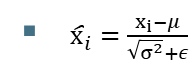

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # Layer Normalization
        # Refer to above equation
        ln = ("...fill here...")
        ln = self.a_2 * ln + self.b_2
        return ln

Residual connection [(cite)](https://arxiv.org/abs/1512.03385)을 적용한 후 layer normalization [(cite)](https://arxiv.org/abs/1607.06450)을 수행한다. 이는 2개의 각 sublayer에 대해 모두 적용한다. 즉, 각 sublayer의 출력은 $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$와 같다. $\mathrm{Sublayer}(x)$는 attention과 feed-forward network와 같다. 각 sublayer의 출력에 dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html)을 적용할 수 있다.

Residual connection을 이용하기 위해 임베딩 레이어를 포함한 모델의 모든 sublayer들은 $d_{\text{model}}=512$ 차원의 출력을 생성한다. Residual connection을 통해 하위 레이어의 데이터가 연산을 거치면서 손실되는 것을 방지할 수 있다. 

In [ ]:
class SublayerConnection(nn.Module): # layer normalization 후 residual connection 수행
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        residual connection을 적용
        코드 작성 편의를 위해 normalization 이후 residual을 적용하였음.
        """
        return x + self.dropout(sublayer(self.norm(x)))

### Decoder

인코더와 동일하게, 디코더 또한 동일한 $N=6$개의 레이어를 쌓음으로써 구성된다.


In [ ]:
class Decoder(nn.Module):# masking이 추가된 N개 레이어를 갖는 decoder
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

인코더에서는 서브레이어가 두 개였는데, 디코더에서는 세 개로 구성된다. 첫째로 <b>masked multi-head self attention</b>을, 그 다음으로 인코더의 출력에 대한 <b>multi-head attention</b>을 수행하는 layer로 구성된다. 마지막에는 <b>feed-forward network layer</b>로 구성되어 있다. 인코더와 마찬가지로 각 서브레이어의 출력과 residual connection 후 Layer Normalization을 수행한다.

In [ ]:
class DecoderLayer(nn.Module):# self attention, source attention, feed forward로 구성
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # 인코더의 output
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # masking을 포함한 self-attention
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # 인코더 output과의 어텐션
        return self.sublayer[2](x, self.feed_forward)

### 어텐션

어텐션은 query, key, value에 대한 함수라고 볼 수 있다. query, key, value는 물론, 어텐션의 결과 또한 벡터이다. 결과는 value의 weighted sum으로 계산된다. 그 weight는 각 value에 할당되는데, 이 값은 query와, 해당하는 key 간의 compatibility 함수를 통해 계산된다.

여기서 사용할 어텐션은 "scaled dot-product attention"이다. query 및 key는 $d_k$ 차원, value는 $d_v$ 차원으로 이루어진다. query와 모든 key간 dot product를 수행한 후, 그 결과를 $\sqrt{d_k}$로 나눈다. 이후 softmax 함수를 사용하여 value에 대한 weight를 구한다.

실제로는 모든 query에 대해 동시에 계산한다. 여기서 모든 query를 하나의 행렬로 나타낸 것을 $Q$라고 하자. key와 value들 또한 하나의 행렬($K$ 및 $V$)로 나타낸다. 어텐션 연산 결과 행렬을 다음을 통해 구할 수 있다:

$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Scaled-Dot Product Attention을 수행
    Query: ((head의 수), query 벡터의 수, d_k)
    Key:   ((head의 수), key 벡터의 수, d_k)
    Value: ((head의 수), value 벡터의 수, d_v)
    """
    d_k = query.size(-1)
    
    # Query와 Key 간 연산 (dot product)
    # 1) 제곱근 구하는 함수: math.sqrt(x)
    # 2) 행렬의 전치: x.transpose(axis1, axis2)
    # 3) 행렬간 곱: torch.matmul(X, Y)
    scores = ("...fill here...")

    if mask is not None: # masking 수행
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # Softmax
    # softmax 구하는 함수: F.softmax()
    p_attn = ("...fill here...")
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

가장 많이 사용되는 어텐션 함수는 additive attention [(cite)](https://arxiv.org/abs/1409.0473)과 dot-product (multiplicative) attention이다. scaling factor가 $\frac{1}{\sqrt{d_k}}$로 다르다는 점만 빼면 여기서 사용하는 어텐션은 dot-product attention과 동일하다. 이론적으로, 계산 복잡도라는 측면에서 두 방식은 동일하지만 dot-product attention이 더 빠르고, 메모리 공간도 덜 사용한다. 고도로 최적화된 행렬곱 코드를 기반으로 구현할 수 있기 때문이다.

$d_k$가 작으면 두 방식은 비슷하게 동작한다. 그러나 $d_k$가 큰 경우 scaling 없이는 additive attention이 더 나은 성능을 보인다[(cite)](https://arxiv.org/abs/1703.03906). 여기서, 원저자들은 $d_k$가 커지면, dot product의 결과 값이 매우 커지고, 따라서 softmax 함수가 아주 작은 미분(gradient)값을 가질 수 있다고 생각하였다. 이를 타개하기 위해 $\frac{1}{\sqrt{d_k}}$ 값으로 scaling한다.

multi-head 어텐션을 통해, 모델이 서로 다른 representation 부공간(subspace)에서 얻을 수 있는 정보에 동시에 attend 할 수 있다. 즉, 한 문장의 여러 부분에 대해 어텐션을 할 수 있다는 것이다. single-head 어텐션에서는 평균을 취하기 때문에 그렇게 하지 못한다.

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                 

파라미터 행렬 $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$, $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$ 을 사용하여 각 부공간에 사영(projection)된다.

본 논문에서는 $h=8$로 지정하여, $d_k=d_v=d_{\text{model}}/h=64$ 값을 갖도록 하였다. 차원이 축소되었기 때문에 전체적으로 보면 single-head 어텐션과 비슷한 연산량을 갖는다.

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "모델의 크기 및 head의 수(h)를 입력받음"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 모든 head들에 대해 동일한 mask를 적용.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) batch내의 모든 데이터에 대해 선형 변환 => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value))]
        
        # 2) batch내 사영된 모든 데이터들에 대해 어텐션 수행
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        # 3) "Concatenation" 후, 선형 변환
        # contiguous 함수는 텐서의 형태 변환(view 함수)을 위해 사용
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Masking
디코더에서, self attention 부분에 masking이 추가된다. 이는 각 위치에서, 이후 위치에 대해 어텐션을 하지 못하도록 한다. Masking을 통해 $i$번째 위치에서 예측할 때, 오직 알고 있는, 즉 $i$ 이전의 결과에 대해서만 의존하도록 한다.

In [ ]:
def subsequent_mask(size):
    "각 위치의 이후 위치에 mask를 적용"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    mask_torch = (torch.from_numpy(subsequent_mask) == 0)
    return mask_torch.to(device)

아래에서 보여주는 그래프는 각 target의 word(row)가 의존할 수 있는 위치(column)를 나타낸다. 학습 과정에서 각 word들이 이후의 단어에 대해 attention을 하지 못하도록 차단한다. 

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(10).cpu()[0])

### 트랜스포머 모델에 적용한 어텐션

트랜스포머 모델에 적용된 어텐션을 다음과 같이 정리할 수 있다:

1) 인코더-디코더 어텐션 레이어에서, query는 직전의 디코더 레이어의 출력값, key와 value는 인코더의 출력값을 사용한다. 이는 디코더의 각 모든 위치에서 입력 문장의 모든 위치에 대해 attend 할 수 있도록 한다. seq2seq 방식의 인코더-디코더를 흉내낼 수 있다.

2) 인코더의 self-attention은 query, key, value가 모두 입력 벡터로 같다. 정확히는 직전 단계 인코더의 출력값이라고 볼 수 있다. 인코더의 각 위치에서 직전 인코더 출력값의 모든 위치에 대해 attend 할 수 있다.

3) 디코더에서도 2)와 비슷하다. 다만, leftward information(문장의 오른쪽에서 왼쪽으로 전달되는 정보)를 차단하기 위해, 어텐션 내부에서 softmax함수의 입력값에 mask를 적용한다($-\infty$로 덧씌움). 디코더에서 leftward information을 차단하는 이유는 auto-regressive 특성을 보존하기 위함이다.

## Position-wise Feed-Forward Networks

어텐션 수행 후 fully connected layer를 통과한다. 이는 각 위치에 대해 독립적으로, 그러나 똑같이 적용된다. 선형변환 후, 활성 함수로 ReLU를 적용하고 나서, 다시 선형 변환을 수행한다.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

각 위치에 대해 선형 변환을 수행할 때 각 레이어는 서로 다른 parameter를 갖는다. kernel size = 1인 두 개의 convolution이 있다고 생각해도 될 것이다. 입력 및 출력의 차원은 $d_{\text{model}}=512$이고, 내부 레이어의 차원은 $d_{ff}=2048$이다. 모든 위치에서 모두 같은 weight parameter를 공유하지만, 각 레이어에 따라서 달라진다.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """
    Feed forward network
    선형 레이어 2개와, ReLU 함수로 구성
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 임베딩 및 Softmax

여타 다른 시퀀스 변환모델과 같이, 입/출력되는 단어들을 $d_{\text{model}}$차원의 벡터로 바꾸기 위해 미리 학습된 임베딩을 사용한다. 또한 다음 단어의 예측 확률을 구하기 위해 선형 변환 및 softmax 함수를 사용한다. 여기서, 임베딩 레이어 및 softmax 직전 선형 변환 레이어에서 동일한 weight matrix를 갖는다. 임베딩 레이어의 weight에 $\sqrt{d_{\text{model}}}$를 곱해준다. 

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

## Positional Encoding
트랜스포머 모델의 특징으로, 순환(recurrence) 구조도 없고 convolution 구조도 없다. 문장 내 단어들의 순서 정보를 사용할 수 있도록, 각 단어들의 상대적/절대적인 위치 정보를 추가해 줄 필요가 있다. 이를 위해 각 단어의 "positional encoding" 정보를 구한 다음 임베딩에 추가하여, 인코더 및 디코더의 입력으로 해줄 수 있다. 물론, positional encoding 또한 벡터이고, $d_{\text{model}}$ 차원을 갖는다. 여러가지 방법이 있겠지만, 여기서는 서로 다른 주기를 갖는 삼각함수(사인 및 코사인)를 사용하여 구하도록 한다. 

$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$             

$pos$는 단어의 위치, $i$는 차원을 의미한다. 즉, positional encoding의 각 차원은 하나의 사인 곡선에 해당한다. 파장은 $2\pi$에서 $10000 \cdot 2\pi$까지 변하게 된다. 본 논문의 저자들은 이러한 함수를 사용함으로써 모델이 상대적인 위치에 따라 더 나은 attention 결과를 보일 수 있다는 가설을 세웠다. 고정된 offset $k$에 대해, $PE_{pos+k}$는 $PE_{pos}$의 선형 함수로 나타내어 질 수 있기 때문이다. 추가로, dropout을 적용할 수도 있다. 기본적으로는 $P_{drop}=0.1$를 사용한다. 

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # 로그를 사용하여 한번에 positional encoding을 계산
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len).unsqueeze(1) # 위 수식에서 'pos'에 해당, shape=(max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model)) # 위 수식에서 1/10000^(2i/d_model)에 해당, shape=(d_model/2, )
        # Positional Encoding
        # 차원이 홀수인 경우: cos 함수 사용
        # 차원이 짝수인 경우: sin 함수 사용
        pe[:, 0::2] = ("...fill here...")
        pe[:, 1::2] = ("...fill here...")
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

아래 코드를 통해 $i$값에 따른 positional encoding이 어떻게 변화하는 지 확인할 수 있다.

In [ ]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20, requires_grad=True))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

본 논문의 저자들은 positional encoding을 학습하도록 하는 모델[(cite)](https://arxiv.org/pdf/1705.03122.pdf)도 실험을 진행하였는데, 결과적으로 사인곡선을 사용하는 방법이나 학습하도록 하는 방법 모두 같은 결과를 보였다고 한다. 여기서 사인곡선을 이용한 것은 모델이 학습하는 동안 다루었던 것보다 훨씬 더 긴 문장을 마주하였을 때에도 추론을 잘 할 수 있기 때문이다.

## Full Model

다음 함수는 hyperparameter 및 각 구성요소들을 정의하여, 하나의 완전한 트랜스포머 모델을 리턴해준다.

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N), # 인코더
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),                   # 디코더
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)), # source 문장의 임베딩 레이어
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)), # target 문장의 임베딩 레이어
        Generator(d_model, tgt_vocab))                              # 문장 생성기
    
    # 모델 파라미터 초기화
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        p = p.to(device)
            
    return model

# Training

여기서부터는 트랜스포머 모델의 학습 과정에 필요한 함수 및 클래스를 정의할 것이다.

## Batches and Masking

일반적인 인코더-디코더 모델을 학습하기 위해 필요한 몇 가지 유용한 코드를 정의할 것이다. 먼저 학습을 위해 source 및 target 문장들을 갖고 있는 batch 클래스 및 masking을 수행하는 함수를 함께 정의할 것이다.

In [ ]:
class Batch: # 학습하는 동안 필요한 데이터 및 mask를 갖고 있는 클래스
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2).to(device)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        # padding된 영역 및 이후 위치에 대한 mask를 생성
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask.to(device)

## Training Loop
다음으로 학습 및 scoring 함수를 정의하여 loss 값을 지속적으로 확인하고자 한다. parameter를 갱신하는 loss 계산함수를 함수의 인자로 전달한다.

In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        # GPU 텐서로 변환
        src = batch.src.to(device)
        trg = batch.trg.to(device)
        src_mask = batch.src_mask.to(device)
        trg_mask = batch.trg_mask.to(device)
        
        out = model.forward(src, trg, src_mask, trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Optimizer

$\beta_1=0.9$, $\beta_2=0.98$, $\epsilon=10^{-9}$로 설정된 Adam optimizer를 사용한다. 학습이 진행되면서 learning rate를 다음 공식에 따라 변화시킨다.

$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$

처음 $warmup\_steps$ 횟수 동안 learning rate가 선형적으로 증가한다. 이후 점차 일정 비율(step수의 -1/2 승)로 감소한다. 여기서는 $warmup\_steps=4000$으로 설정하였다.                         

In [ ]:
class NoamOpt:
    def __init__(self, model_size, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0
        
    def step(self): # parameter 및 learning rate를 업데이트
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None): # lrate를 계산
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

다음은 learning rate가 어떻게 변화하는 지 보여주는 그래프이다. 그래프의 범례를 보면 x:y 형태인데, x는 $step\_num$, y는 $warmup\_steps$ 이다. 

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 4000, None), 
        NoamOpt(512, 8000, None),
        NoamOpt(256, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Loss 계산 함수
loss 계산 후, normalization 된 값을 되돌려준다. 

In [ ]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

# A Real World Example

이제 torchtext를 통해 데이터를 불러와서 학습을 시켜보자. Multi30k 데이터셋을 사용하고자 한다. 평균적으로 13개의 단어로 구성된 30000개의 영어 및 독어 문장을 불러와, 이를 학습하여 영-독 번역기를 학습한다. Spacy를 Tokenizer로서 사용한다.

다음 세 명령어를 터미널에 입력하여, torchtext및 spacy를 설치하고, spacy의 영어 및 독어 tokenizer를 다운로드한다. 
```bash
pip install torchtext spacy
python -m spacy download en
python -m spacy download de
```

## Data Loading
torchtext를 이용하여 Multi30k 데이터셋을 불러온다.

In [ ]:
# For data loading.
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize = 'spacy',
            tokenizer_language='de',
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize='spacy',
            tokenizer_language='en',
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'),
                                                    fields=(SRC, TRG))

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

## BucketIterator
다음은 torchtext에서 제공하는 BucketIterator를 사용하여 데이터셋을 batch 단위로 나누고, iterator를 생성한다. for문과 같은 반복문을 통해 각 batch에 순차적으로 접근할 수 있다.

In [ ]:
BATCH_SIZE = 128

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device
)

def rebatch(pad_idx, batch):
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg,)

다음으로, 모델 및 optimizer를 정의한다.

In [ ]:
pad_idx = TRG.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TRG.vocab), N=6)
crit = nn.CrossEntropyLoss()

# GPU를 통해 병렬 처리 가능
model_par = nn.DataParallel(model, device_ids=[device])

optim = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Training

In [ ]:
for epoch in range(10):
    model_par.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                model_par, 
                SimpleLossCompute(model.generator, crit , opt=optim))
    model_par.eval()
    loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                        model_par, 
                        SimpleLossCompute(model.generator, crit, opt=None))
    print(loss)

우리가 학습시킨 모델이 어떤 결과를 내는지 <b>greedy decoding</b>을 통해 확인해보자.

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           ys, 
                           subsequent_mask(ys.size(1))
                                    .type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    print("\n    원문:", end='\t')
    for j in range(1, batch.src.size(0)):
        sym = SRC.vocab.itos[batch.src.data[j, 0]]
        if sym == "<eos>": break
        print(sym, end =" ")
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TRG.vocab.stoi["<sos>"])
    print("\n기계번역:", end="\t")
    for j in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, j]]
        if sym == "<eos>": break
        print(sym, end =" ")
    print("\n실제번역:", end="\t")
    for j in range(1, batch.trg.size(0)):
        sym = TRG.vocab.itos[batch.trg.data[j, 0]]
        if sym == "<eos>": break
        print(sym, end =" ")
        
    if i == 2: # 3개까지만 출력
        break
    
    print("="*20)